Imports (cf code de Yorick) : 

In [47]:
# import cv2
import torch
import torch.nn as nn
from torchvision.models import vgg19
from torchvision.models import VGG19_Weights
import numpy as np

autres imports ?

In [48]:
import matplotlib.pyplot as plt
from PIL import Image
import os, json
from torchvision import models, transforms
from torch.autograd import Variable
import torch.nn.functional as F

copie du code originel 

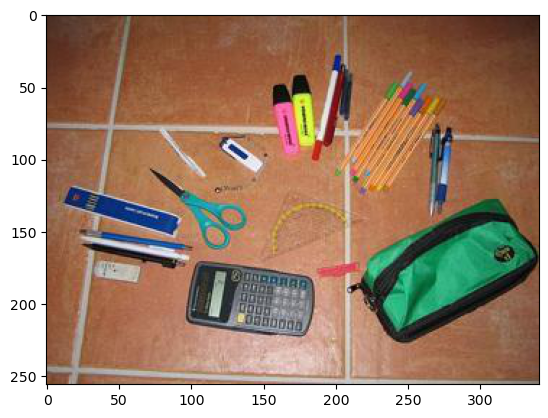

In [49]:
def get_image(path):
    with open(os.path.abspath(path), 'rb') as f:
        with Image.open(f) as img:
            return img.convert('RGB') 
        
img = get_image('./Images/Trousse.jpg')
plt.imshow(img)

-----

In [50]:
# resize and take the center part of image to what our model expects
def get_input_transform():
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])       
    transf = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        normalize
    ])    

    return transf

def get_input_tensors(img):
    transf = get_input_transform()
    # unsqeeze converts single image to batch of 1
    return transf(img).unsqueeze(0)

In [51]:
model = vgg19(pretrained=True)

In [52]:
idx2label, cls2label, cls2idx = [], {}, {}
with open(os.path.abspath('./imagenet_class_index.json'), 'r') as read_file:
    class_idx = json.load(read_file)
    idx2label = [class_idx[str(k)][1] for k in range(len(class_idx))]
    cls2label = {class_idx[str(k)][0]: class_idx[str(k)][1] for k in range(len(class_idx))}
    cls2idx = {class_idx[str(k)][0]: k for k in range(len(class_idx))}   

In [53]:

#String variable to store the predictions
pred_res = ""

def process_image(image_to_process, file_name) :

    global pred_res

    #dissect the vgg19 network

    class VGG(nn.Module):
        def __init__(self):
            super(VGG, self).__init__()
        
            # get the pretrained VGG19 network
            self.vgg = vgg19(weights=VGG19_Weights.DEFAULT)
        
            # disect the network to access its last convolutional layer
            # self.features_conv = self.vgg.features[:36]
        
            # get the max pool of the features stem
            # self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        
            # get the classifier of the vgg19
            self.classifier = self.vgg.classifier
        
            # placeholder for the gradients
            self.gradients = None
    
        # hook for the gradients of the activations
        def activations_hook(self, grad):
            self.gradients = grad
        
        def forward(self, x):
            x = self.features_conv(x)
        
            # register the hook
            h = x.register_hook(self.activations_hook)
        
            # apply the remaining pooling
            x = self.max_pool(x)
            x = x.view((1, -1))
            x = self.classifier(x)
            return x
    
        # method for the gradient extraction
        def get_activations_gradient(self):
            return self.gradients
    
        # method for the activation exctraction
        def get_activations(self, x):
            return self.features_conv(x)
            # initialize the VGG model
    vgg = VGG()

    # set the evaluation mode
    vgg.eval()
    # get the most likely prediction of the model
    pred = vgg19(image_to_process)

    #Get the class_id whith the most probability
    pred2 = pred.squeeze(0).softmax(0)
    class_id = pred2.argmax().item()
    score = pred2[class_id].item()

    #Get the matched category name from the matching class_id
    category_name = VGG19_Weights.DEFAULT.meta["categories"][class_id]

    #Write the prediction into the pred_res variable
    pred_res += ("Prediction for "+file_name+f" : {category_name} / {100 * score:.1f}%\n")

 

In [54]:
def new_predict_fn(images):
   images = skimage_to_vgg(images)
   return predict_fn(images)

Pour avoir la prédiction principale (code de Yorick)

In [55]:
# process_image(img,'./Images/Trousse.jpg')

In [56]:
img_t = get_input_tensors(img)
model.eval()
logits = model(img_t)
probs = F.softmax(logits, dim=1)
probs5 = probs.topk(5)
tuple((p,c, idx2label[c]) for p, c in zip(probs5[0][0].detach().numpy(), probs5[1][0].detach().numpy()))

((0.2491732, 477, "carpenter's_kit"),
 (0.13766833, 840, 'swab'),
 (0.12754029, 767, 'rubber_eraser'),
 (0.07711352, 784, 'screwdriver'),
 (0.062180642, 462, 'broom'))

In [57]:
def get_pil_transform(): 
    transf = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop(224)
    ])    

    return transf

def get_preprocess_transform():
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])     
    transf = transforms.Compose([
        transforms.ToTensor(),
        normalize
    ])    

    return transf    

pill_transf = get_pil_transform()
preprocess_transform = get_preprocess_transform()

In [58]:
def batch_predict(images):
    model.eval()
    batch = torch.stack(tuple(preprocess_transform(i) for i in images), dim=0)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    batch = batch.to(device)
    
    logits = model(batch)
    probs = F.softmax(logits, dim=1)
    return probs.detach().cpu().numpy()

In [59]:
test_pred = batch_predict([pill_transf(img)])
test_pred.squeeze().argmax() # le numéro renvoyé est le num correspondant dans le imagenet_class_index

477

In [60]:
from lime import lime_image

In [61]:
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(np.array(pill_transf(img)), 
                                         batch_predict, # classification function
                                         top_labels=5, 
                                         hide_color=0, 
                                         num_samples=1000) # number of images that will be sent to classification function

  0%|          | 0/1000 [00:00<?, ?it/s]

In [62]:
from skimage.segmentation import mark_boundaries

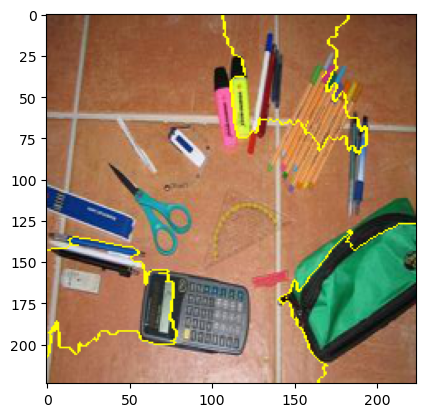

In [63]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
img_boundry1 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry1)

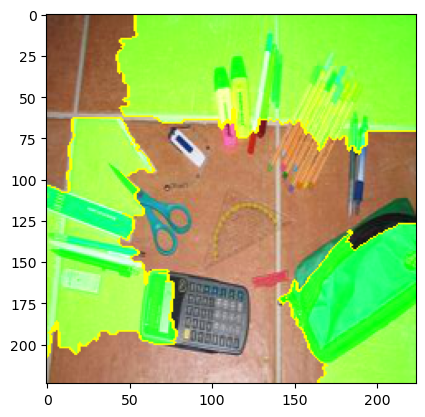

In [64]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
img_boundry2 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry2)